# Notebook 5 — Finite Element Method for Option Pricing

The **Galerkin finite-element method (FEM)** provides an alternative PDE discretisation to finite differences. Instead of approximating derivatives at grid points, FEM expands the solution in a set of **basis functions** and enforces the PDE in a *weak* (integral) sense.

For the BS PDE on $x = \ln S$ with piecewise-linear (hat) basis functions $\phi_j(x)$, the semi-discrete system is

$$M \dot{V} + K V = 0$$

where $M$ is the **mass matrix** and $K$ is the **stiffness matrix** assembled from the bilinear form:

$$a(V, \phi) = \int \tfrac{\sigma^2}{2} V' \phi' - \mu V' \phi + r V \phi \, dx, \qquad \mu = r - q - \sigma^2/2$$

Time integration uses the same $\theta$-scheme as the FD solver, yielding a tridiagonal system at each step.

This notebook demonstrates:

1. FEM pricing vs Black-Scholes (accuracy check)
2. FEM vs FDM cross-comparison
3. Convergence analysis — error vs grid size
4. FEM price surface visualisation

**Reference**: Topper, *Financial Engineering with Finite Elements* (Wiley, 2005).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import replace

import optpricer as op
from optpricer.fem import fem_price
from optpricer.pde import fd_price

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

## 1. FEM vs Black-Scholes — Accuracy Check

We price ATM European calls and puts with FEM and compare against the closed-form BS values.

In [2]:
opt = op.OptionSpec(S0=100, K=100, T=1.0, r=0.05, sigma=0.20, q=0.02)

print(f"{'Kind':<6} {'BS':>12} {'FEM':>12} {'|Err|':>12} {'Rel Err':>12}")
print("-" * 56)
for kind, label in [(op.CALL, "Call"), (op.PUT, "Put")]:
    bs  = op.bs_price(opt, kind)
    fem = fem_price(opt, kind, N_S=400, N_t=400)
    err = abs(fem - bs)
    rel = err / bs * 100
    print(f"{label:<6} {bs:>12.6f} {fem:>12.6f} {err:>12.6f} {rel:>11.4f}%")

Kind             BS          FEM        |Err|      Rel Err
--------------------------------------------------------
Call       9.227006     9.226907     0.000098      0.0011%
Put        6.330081     6.329949     0.000132      0.0021%


## 2. FEM vs FDM Cross-Comparison

Both the FEM and FDM solvers discretise the same PDE on the same log-spot grid. With linear hat functions and a uniform grid, the FEM stiffness matrix is algebraically similar to the FD coefficient matrix, but the **consistent mass matrix** introduces subtle differences.

We compare prices across a range of strikes.

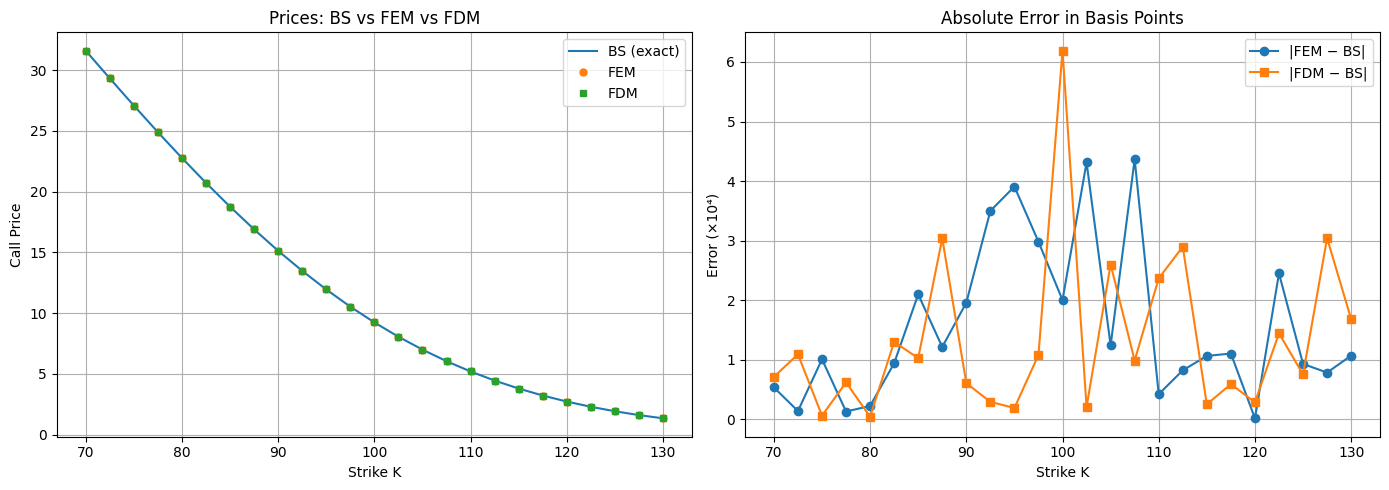

In [3]:
strikes = np.linspace(70, 130, 25)
fem_prices, fdm_prices, bs_prices = [], [], []

for K in strikes:
    o = replace(opt, K=K)
    bs_prices.append(op.bs_price(o, op.CALL))
    fem_prices.append(fem_price(o, op.CALL, N_S=300, N_t=300))
    fdm_prices.append(fd_price(o, op.CALL, N_S=300, N_t=300))

bs_prices = np.array(bs_prices)
fem_prices = np.array(fem_prices)
fdm_prices = np.array(fdm_prices)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(strikes, bs_prices, label="BS (exact)")
ax1.plot(strikes, fem_prices, "o", markersize=5, label="FEM")
ax1.plot(strikes, fdm_prices, "s", markersize=4, label="FDM")
ax1.set_xlabel("Strike K"); ax1.set_ylabel("Call Price")
ax1.set_title("Prices: BS vs FEM vs FDM")
ax1.legend()

ax2.plot(strikes, np.abs(fem_prices - bs_prices) * 1e4, "o-", label="|FEM − BS|")
ax2.plot(strikes, np.abs(fdm_prices - bs_prices) * 1e4, "s-", label="|FDM − BS|")
ax2.set_xlabel("Strike K"); ax2.set_ylabel("Error (×10⁴)")
ax2.set_title("Absolute Error in Basis Points")
ax2.legend()

plt.tight_layout()
plt.show()

Both methods achieve sub-basis-point accuracy. Their errors differ slightly due to the consistent mass matrix (FEM) vs the identity mass (FDM).

## 3. Convergence Analysis

We refine the grid from $N = 25$ to $N = 1600$ and plot the error on a log-log scale. With Crank-Nicolson ($\theta = 0.5$) and linear elements, we expect **second-order** convergence.

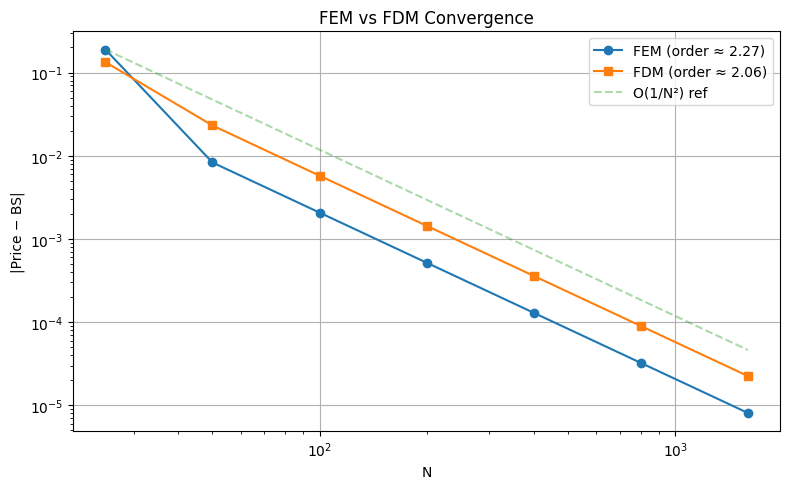

In [4]:
opt_c = op.OptionSpec(S0=100, K=100, T=1.0, r=0.05, sigma=0.20, q=0.0)
bs_ref = op.bs_price(opt_c, op.CALL)

Ns = [25, 50, 100, 200, 400, 800, 1600]
fem_errors = [abs(fem_price(opt_c, op.CALL, N_S=N, N_t=N) - bs_ref) for N in Ns]
fdm_errors = [abs(fd_price(opt_c, op.CALL, N_S=N, N_t=N) - bs_ref) for N in Ns]

# Estimate convergence orders
fem_order = -np.polyfit(np.log(Ns), np.log(fem_errors), 1)[0]
fdm_order = -np.polyfit(np.log(Ns), np.log(fdm_errors), 1)[0]

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(Ns, fem_errors, "o-", label=f"FEM (order ≈ {fem_order:.2f})")
ax.loglog(Ns, fdm_errors, "s-", label=f"FDM (order ≈ {fdm_order:.2f})")
ax.loglog(Ns, [fem_errors[0] * (Ns[0]/N)**2 for N in Ns], "--", alpha=0.4, label="O(1/N²) ref")
ax.set_xlabel("N")
ax.set_ylabel("|Price − BS|")
ax.set_title("FEM vs FDM Convergence")
ax.legend()
plt.tight_layout()
plt.show()

## 4. FEM Price Surface

We generate a price surface $V(K, T)$ computed entirely with the FEM solver. This is the same type of surface shown in Notebook 2, but now computed from the PDE rather than the closed-form formula.

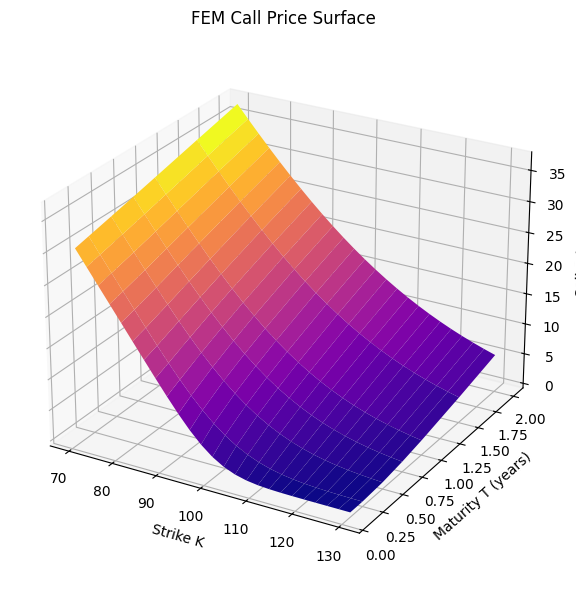

In [5]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

K_vals = np.linspace(70, 130, 25)
T_vals = np.array([0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0])

FEM_surface = np.zeros((len(T_vals), len(K_vals)))
for i, T in enumerate(T_vals):
    for j, K in enumerate(K_vals):
        o = op.OptionSpec(S0=100, K=K, T=T, r=0.05, sigma=0.20, q=0.0)
        FEM_surface[i, j] = fem_price(o, op.CALL, N_S=200, N_t=200)

Kmesh, Tmesh = np.meshgrid(K_vals, T_vals)

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(Kmesh, Tmesh, FEM_surface, cmap="plasma", linewidth=0, antialiased=True)
ax.set_xlabel("Strike K")
ax.set_ylabel("Maturity T (years)")
ax.set_zlabel("Call Price")
ax.set_title("FEM Call Price Surface")
ax.view_init(elev=25, azim=-60)
plt.tight_layout()
plt.show()

### Summary

The FEM solver provides a mathematically rigorous alternative to finite differences for PDE-based option pricing. Key advantages of FEM in higher dimensions include:

- **Unstructured meshes**: FEM naturally handles non-rectangular domains (useful for multi-asset basket options)
- **Adaptive refinement**: mesh can be locally refined near barriers or the strike
- **Variational framework**: error bounds from the weak formulation

In 1D both FEM and FDM produce nearly identical results. The FEM approach shines in **2D and 3D** problems (e.g., spread options, stochastic local volatility).